## 全国版d4PDFダウンスケーリングデータの可視化

[全国版d4PDFダウンスケーリングデータ](https://diasjp.net/ds2022/dataset/ds16.html)
は大規模アンサンブル実験d4PDFの60km格子の全球機構モデルの結果をもとに、
5km格子の地域気候モデルNHRCMを用いて日本全国を対象にダウンスケーリングしたデータである。
このデータはnetcdf形式で保存されているためxarrayのエコシステムで取り扱いやすい。  

しかし、データに緯度・経度情報が紐付けされていないため、
可視化や内挿作業を実施する前に、各格子点に正しい緯度・経度情報を与える必要がある。

ライブラリーをインポートする。

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

以下で用いる地上データは、適当にダウンロードしたファイル  
HFB_2K_CC_m101/2030/daily/2030_daily_surf.nc  
から抽出したサンプルデータである。

海面更正気圧のデータを読み込む。

In [2]:
ds1 = xr.open_dataset("./Data/test_psea_2.nc")
ds1

<xarray.Dataset> Size: 7MB
Dimensions:  (time: 4, lon: 550, lat: 755, lev: 1)
Coordinates:
  * time     (time) datetime64[ns] 32B 2030-12-31T03:00:00 ... 2031-01-03T03:...
  * lon      (lon) float64 4kB 1.0 2.0 3.0 4.0 5.0 ... 547.0 548.0 549.0 550.0
  * lat      (lat) float64 6kB 1.0 2.0 3.0 4.0 5.0 ... 752.0 753.0 754.0 755.0
  * lev      (lev) float64 8B 1.0
Data variables:
    psea     (time, lev, lat, lon) float32 7MB ...
Attributes:
    CDI:          Climate Data Interface version 2.3.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Dec 19 17:06:38 2023: cdo -seltimestep,161/164 test_pse...
    CDO:          Climate Data Operators version 2.3.0 (https://mpimet.mpg.de...

海面更正気圧pseaは、time/lev/lat/lonの四次元データである。  
最初の時刻のpseaを可視化してみる。

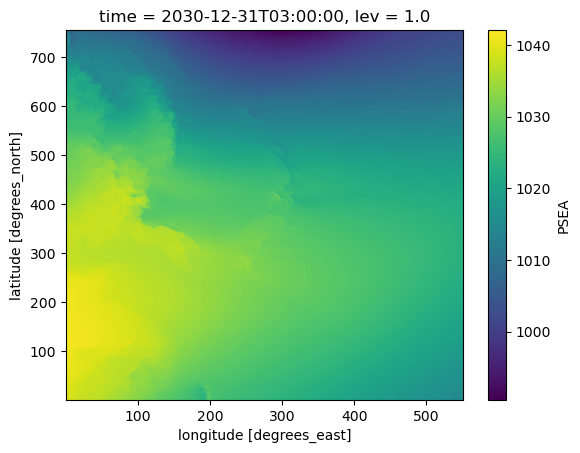

In [3]:
ds1["psea"][0,:,:,:].plot()

ここで緯度と経度は現実の地球のものではなく、仮の緯度・経度が与えられている。  

NHRCMの標高データなどが含まれている"cnst.nc"を読み込む。

In [4]:
ds2 = xr.open_dataset("./Data/cnst.nc")
ds2

<xarray.Dataset> Size: 7MB
Dimensions:  (time: 1, lon: 550, lat: 755, lev: 1)
Coordinates:
  * time     (time) datetime64[ns] 8B 1950-07-20
  * lon      (lon) float64 4kB 1.0 2.0 3.0 4.0 5.0 ... 547.0 548.0 549.0 550.0
  * lat      (lat) float64 6kB 1.0 2.0 3.0 4.0 5.0 ... 752.0 753.0 754.0 755.0
  * lev      (lev) float64 8B 1.0
Data variables:
    zs       (time, lev, lat, lon) float32 2MB ...
    sl       (time, lev, lat, lon) float32 2MB ...
    flat     (time, lev, lat, lon) float32 2MB ...
    flon     (time, lev, lat, lon) float32 2MB ...
Attributes:
    CDI:          Climate Data Interface version 2.1.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Nov 16 14:14:40 2023: cdo -f nc4 -z zip_1 import_binary...
    CDO:          Climate Data Operators version 2.1.0 (https://mpimet.mpg.de...

"cnst.nc"から、それぞれの格子点の緯度・経度の情報である"flat"と"flon"を取り出す。

In [5]:
lat = ds2.flat[0,0,:,:]
lon = ds2.flon[0,0,:,:]
lat

<xarray.DataArray 'flat' (lat: 755, lon: 550)> Size: 2MB
[415250 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 8B 1950-07-20
  * lon      (lon) float64 4kB 1.0 2.0 3.0 4.0 5.0 ... 547.0 548.0 549.0 550.0
  * lat      (lat) float64 6kB 1.0 2.0 3.0 4.0 5.0 ... 752.0 753.0 754.0 755.0
    lev      float64 8B 1.0
Attributes:
    long_name:  latitude

最初の時刻の海面更正気圧を取り出す。

In [6]:
psea = ds1.psea[0,0,:,:]
psea

<xarray.DataArray 'psea' (lat: 755, lon: 550)> Size: 2MB
[415250 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 8B 2030-12-31T03:00:00
  * lon      (lon) float64 4kB 1.0 2.0 3.0 4.0 5.0 ... 547.0 548.0 549.0 550.0
  * lat      (lat) float64 6kB 1.0 2.0 3.0 4.0 5.0 ... 752.0 753.0 754.0 755.0
    lev      float64 8B 1.0
Attributes:
    long_name:  PSEA

lon/lat/pseaを用いて空間分布図を作成する。

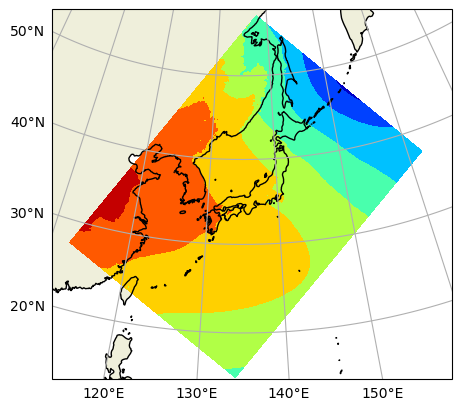

In [7]:
extent = [114, 158, 15, 56]
fig = plt.figure()
ax = plt.axes(projection=ccrs.LambertConformal(
    central_longitude=135,
    central_latitude=35,
    standard_parallels=(30,60))
)
ax.set_extent(extent, ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)

ax.contourf(
    lon, 
    lat, 
    psea,
    cmap='jet', 
    transform=ccrs.PlateCarree()
)

ax.coastlines()
gl = ax.gridlines(
    draw_labels=True,
    x_inline=False,
    y_inline=False,
    xlocs = mticker.MultipleLocator(10),
    ylocs = mticker.MultipleLocator(10),
    linestyle = "-"
)
gl.top_labels=False
gl.bottom_labels=True
gl.left_labels=True
gl.right_labels=False
gl.rotate_labels=False

## curvilinearであるxarray.Datasetの作成

NHRCMのデータには、仮の緯度、仮の経度の情報が座標軸(lon, lat)として格納されている。
これらの仮の緯度・仮の経度が存在するとxESMFの内挿機能は利用できない。

そこで、データの配列（ここではpsea2）と
const.ncに格納されている2次元配列のflat/flonを
用いたxarray.Datasetを作成する。

* [Regrid between curvilinear grids](https://xesmf.readthedocs.io/en/latest/notebooks/Curvilinear_grid.html)
* [Working with multidimensional coordinates](https://docs.xarray.dev/en/stable/examples/multidimensional-coords.html)
* [How to handle 2d latitude and longitude coordinates within DataArray creation #3661](https://github.com/pydata/xarray/issues/3661)

lon/lat/psea を``xarray.DataArray.values``を用いて"numpy.ndarray"に変換する。

In [8]:
psea2 = psea.values
type(psea2)

numpy.ndarray

In [9]:
lon2 = lon.values
lat2 = lat.values

In [10]:
ds3 = xr.Dataset(
    {
        'psea': xr.DataArray(
            data = psea2,
            dims = ["y", "x"],
            coords = {
                "latitude": (["y", "x"],  lat2),
                "longitude": (["y", "x"], lon2)
            }
        )
    }
)
ds3

<xarray.Dataset> Size: 5MB
Dimensions:    (y: 755, x: 550)
Coordinates:
    latitude   (y, x) float32 2MB 27.41 27.39 27.38 27.36 ... 37.44 37.41 37.37
    longitude  (y, x) float32 2MB 112.5 112.5 112.6 112.6 ... 162.0 162.1 162.1
Dimensions without coordinates: y, x
Data variables:
    psea       (y, x) float32 2MB 1.039e+03 1.039e+03 ... 1.002e+03 1.002e+03

ds1とds2では、lonは"(lon)"、latは"(lat)"と表示されており、座標が1次元であることを示しており、こちらは"rectilinearなグリッド"であることを示している。  
一方、ds3では"Coordinates"のlatitudeとlongitudeがそれぞれ"(y,x)"と表示されている点である。
これはデータが"curvilinearなグリッド"、つまり座標が2次元である構造を持っていることを示している。
curvilinearな形のxarray.Datasetを作成することで、各格子点に緯度・経度を紐付けることができた。


ds3を``plot()``を用いてプロットする。

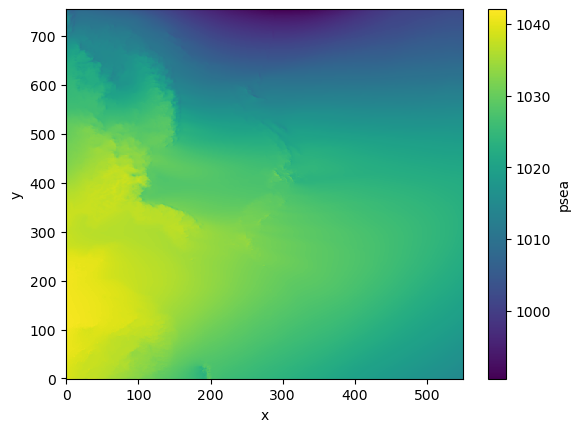

In [11]:
ds3.psea.plot()

単純に``plot()``すると、横軸にx、縦軸にyが用いられてしまう。

2次元の緯度・経度情報を用いて作図する。

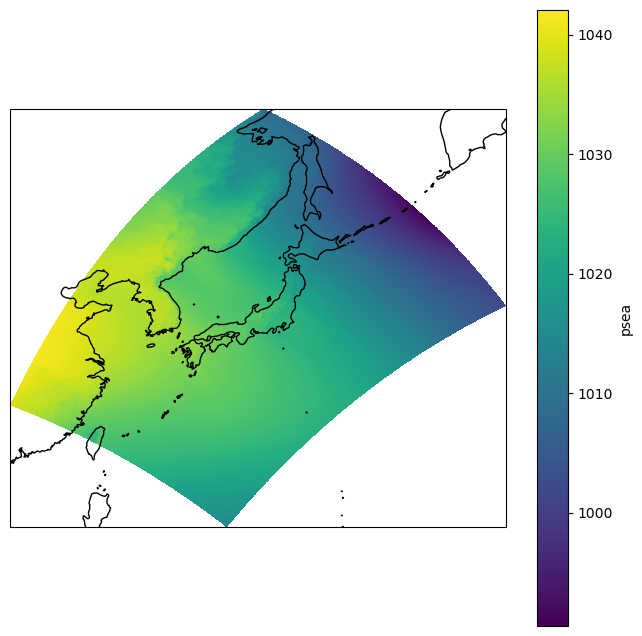

In [12]:
plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ds3.psea.plot.pcolormesh(ax=ax, x="longitude", y="latitude")
ax.coastlines()

curvilinearな構造であるようにxarray.Datasetを作成することにより、
データを希望する投影図法で可視化するだけでなく、
海岸線や河川、湖沼などの情報を重ね書きすることができるようになる。

## xESMFを用いた空間内挿

xarray のエコシステムの中に[xESMF](https://github.com/pangeo-data/xESMF)という
ライブラリーが存在する。
このライブラリーの目的はモデル出力の空間内挿（と時間方向の内挿も）であり、
[Earth System Modeling Framework](https://earthsystemmodeling.org/)の内挿機能を
xarray のエコシステムから利用できるようにする「ラッパー」である。


xESMFを用いて NHRCM のデータを空間内挿したら正しい内挿結果を得られるかを実験する。
なお、xESMFでは6種類の内挿手法が実装されているが、
ここではGrADSで用いられる内挿法と同等である"bilinear"を用いて空間内挿を実施する。

xesmfでregridderを使用する際、緯度は"lat"、経度は"lon"という名前でないといけない。
そのため変数の名前を変更する。

In [13]:
ds3 = ds3.rename({"latitude": "lat", "longitude": "lon"})
ds3

<xarray.Dataset> Size: 5MB
Dimensions:  (y: 755, x: 550)
Coordinates:
    lat      (y, x) float32 2MB 27.41 27.39 27.38 27.36 ... 37.44 37.41 37.37
    lon      (y, x) float32 2MB 112.5 112.5 112.6 112.6 ... 162.0 162.1 162.1
Dimensions without coordinates: y, x
Data variables:
    psea     (y, x) float32 2MB 1.039e+03 1.039e+03 ... 1.002e+03 1.002e+03

データとともに配布されるGrADSのctlファイルでデータを開いたときに、
GrADSの機能で自動的に内挿する領域に近い領域をregrid先の座標として設定する。

In [14]:
ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(15, 57.1, 0.03), {"units": "degrees_north"}),
        "lon": (["lon"], np.arange(112, 162.1, 0.03), {"units": "degrees_east"}),
    }
)
ds_out

<xarray.Dataset> Size: 25kB
Dimensions:  (lat: 1404, lon: 1670)
Coordinates:
  * lat      (lat) float64 11kB 15.0 15.03 15.06 15.09 ... 57.03 57.06 57.09
  * lon      (lon) float64 13kB 112.0 112.0 112.1 112.1 ... 162.0 162.0 162.1
Data variables:
    *empty*

regridするデータをxarray.DataArrayにする。

In [15]:
da = ds3["psea"]
da

<xarray.DataArray 'psea' (y: 755, x: 550)> Size: 2MB
array([[1039.2677 , 1039.2233 , 1039.4492 , ..., 1014.7115 , 1014.6819 ,
        1014.64746],
       [1039.1101 , 1039.0112 , 1038.9607 , ..., 1014.7411 , 1014.7094 ,
        1014.67395],
       [1039.1886 , 1039.0255 , 1038.971  , ..., 1014.78784, 1014.75165,
        1014.71606],
       ...,
       [1013.9788 , 1011.69354, 1010.63965, ..., 1002.1414 , 1002.1285 ,
        1002.1176 ],
       [1013.8451 , 1011.6606 , 1010.74036, ..., 1002.1138 , 1002.1008 ,
        1002.08246],
       [1013.2827 , 1011.61664, 1011.0956 , ..., 1002.08575, 1002.06024,
        1002.0531 ]], dtype=float32)
Coordinates:
    lat      (y, x) float32 2MB 27.41 27.39 27.38 27.36 ... 37.44 37.41 37.37
    lon      (y, x) float32 2MB 112.5 112.5 112.6 112.6 ... 162.0 162.1 162.1
Dimensions without coordinates: y, x

xe.Regridderを用いて"regridder"の作成。ここは時間がかかる。

In [16]:
regridder = xe.Regridder(ds3, ds_out, "bilinear")

"regridder"を用いて、海面更正気圧を内挿する。

In [17]:
da_out = regridder(da)

内挿した結果を作図する。

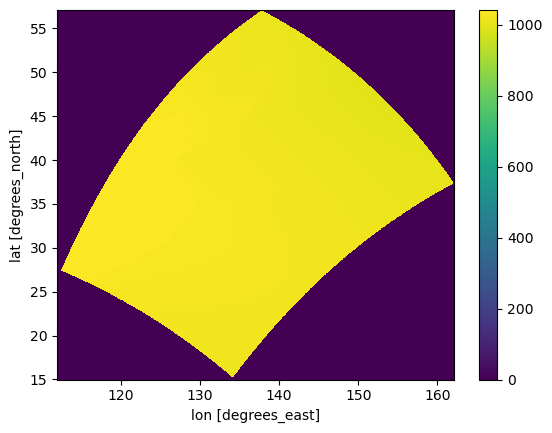

In [18]:
da_out.plot()

NHRCMのデータの存在しない領域がおかしな色になっている。

配列を確認する。

In [19]:
da_out

<xarray.DataArray (lat: 1404, lon: 1670)> Size: 9MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * lat      (lat) float64 11kB 15.0 15.03 15.06 15.09 ... 57.03 57.06 57.09
  * lon      (lon) float64 13kB 112.0 112.0 112.1 112.1 ... 162.0 162.0 162.1
Attributes:
    regrid_method:  bilinear

regridの結果、NHRCMのデータが存在しない領域にはどうやら"0"が埋められており、
公式ドキュメントを読んだ限り、これは仕様らしい。

たまたま海面更正気圧だったので、データと"0"はきれいに分離できる。
そこで``where()``を用いて numpy.nan に置換する。

In [20]:
da_masked = da_out.where(da_out != 0.0)
da_masked

<xarray.DataArray (lat: 1404, lon: 1670)> Size: 9MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat      (lat) float64 11kB 15.0 15.03 15.06 15.09 ... 57.03 57.06 57.09
  * lon      (lon) float64 13kB 112.0 112.0 112.1 112.1 ... 162.0 162.0 162.1
Attributes:
    regrid_method:  bilinear

numpy.nanの入ったデータを可視化する。

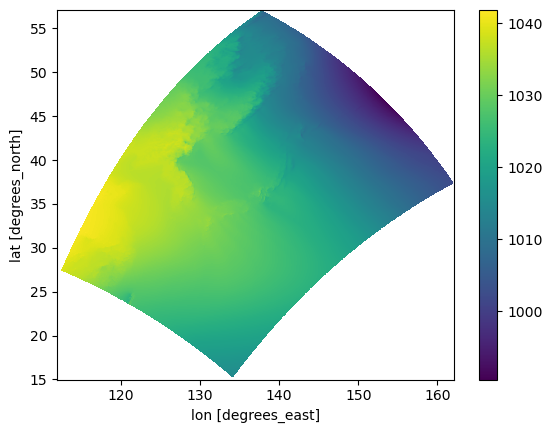

In [21]:
da_masked.plot()

ランベルト正角円錐図法での作図。

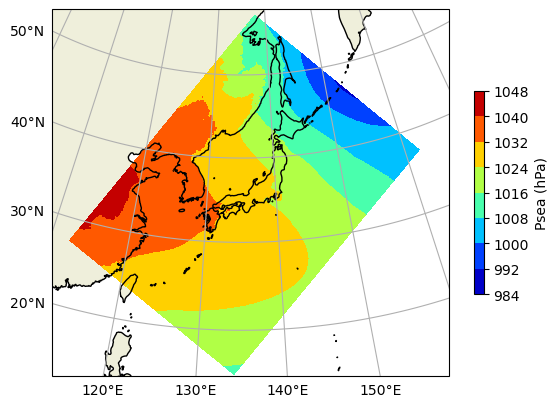

In [22]:
extent = [114, 158, 15, 56]
fig = plt.figure()
ax = plt.axes(projection=ccrs.LambertConformal(
    central_longitude=135,
    central_latitude=35,
    standard_parallels=(30,60))
)
ax.set_extent(extent, ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)

im = ax.contourf(
    da_masked.lon,
    da_masked.lat,
    da_masked,
    cmap="jet",
    transform=ccrs.PlateCarree()
)
cbar = plt.colorbar(im, shrink=0.55, label="Psea (hPa)")

ax.coastlines()
gl = ax.gridlines(
    draw_labels=True,
    x_inline=False,
    y_inline=False,
    xlocs = mticker.MultipleLocator(10),
    ylocs = mticker.MultipleLocator(10),
    linestyle = "-"
)
gl.top_labels=False
gl.bottom_labels=True
gl.left_labels=True
gl.right_labels=False
gl.rotate_labels=False

後々のことも考えて、``notnull()``を用いてmaskを作成する。

In [23]:
mask = da_masked.notnull()
mask

<xarray.DataArray (lat: 1404, lon: 1670)> Size: 2MB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * lat      (lat) float64 11kB 15.0 15.03 15.06 15.09 ... 57.03 57.06 57.09
  * lon      (lon) float64 13kB 112.0 112.0 112.1 112.1 ... 162.0 162.0 162.1

作成したmaskを可視化してみる。

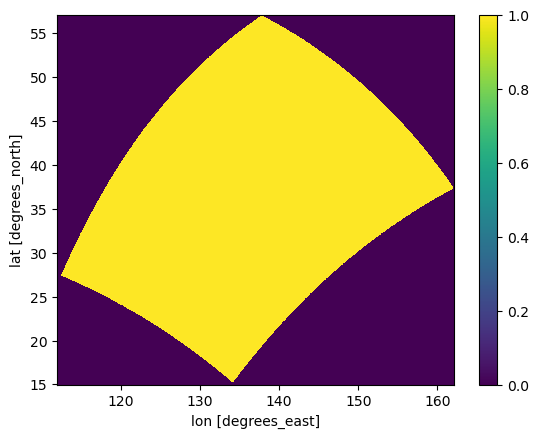

In [24]:
mask.plot()

## 風速データの内挿と可視化

風のデータを読み込む。

In [25]:
ds5 = xr.open_dataset("./Data/test_u_rot_2.nc")
ds5

<xarray.Dataset> Size: 7MB
Dimensions:  (time: 4, lon: 550, lat: 755, lev: 1)
Coordinates:
  * time     (time) datetime64[ns] 32B 2030-12-31T03:00:00 ... 2031-01-03T03:...
  * lon      (lon) float64 4kB 1.0 2.0 3.0 4.0 5.0 ... 547.0 548.0 549.0 550.0
  * lat      (lat) float64 6kB 1.0 2.0 3.0 4.0 5.0 ... 752.0 753.0 754.0 755.0
  * lev      (lev) float64 8B 1.0
Data variables:
    u_rot    (time, lev, lat, lon) float32 7MB ...
Attributes:
    CDI:          Climate Data Interface version 2.3.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Dec 19 17:07:00 2023: cdo -seltimestep,161/164 test_u_r...
    CDO:          Climate Data Operators version 2.3.0 (https://mpimet.mpg.de...

In [26]:
ds6 = xr.open_dataset("./Data/test_v_rot_2.nc")
ds6

<xarray.Dataset> Size: 7MB
Dimensions:  (time: 4, lon: 550, lat: 755, lev: 1)
Coordinates:
  * time     (time) datetime64[ns] 32B 2030-12-31T03:00:00 ... 2031-01-03T03:...
  * lon      (lon) float64 4kB 1.0 2.0 3.0 4.0 5.0 ... 547.0 548.0 549.0 550.0
  * lat      (lat) float64 6kB 1.0 2.0 3.0 4.0 5.0 ... 752.0 753.0 754.0 755.0
  * lev      (lev) float64 8B 1.0
Data variables:
    v_rot    (time, lev, lat, lon) float32 7MB ...
Attributes:
    CDI:          Climate Data Interface version 2.3.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Dec 19 17:07:06 2023: cdo -seltimestep,161/164 test_v_r...
    CDO:          Climate Data Operators version 2.3.0 (https://mpimet.mpg.de...

風のデータの各格子点に緯度・経度情報を紐付けして、xarray.Datasetを作成する。

In [27]:
ds7 = xr.Dataset(
    {
        'u': xr.DataArray(
            data = ds5["u_rot"][0,0,:,:],
            dims = ["y", "x"],
            coords = {
                "lat": (["y", "x"], lat2),
                "lon": (["y", "x"], lon2)
            }
        ),
        'v': xr.DataArray(
            data = ds6["v_rot"][0,0,:,:],
            dims = ["y", "x"],
            coords = {
                "lat": (["y", "x"], lat2),
                "lon": (["y", "x"], lon2)
            }
        )
    }
)
ds7

<xarray.Dataset> Size: 7MB
Dimensions:  (y: 755, x: 550)
Coordinates:
    lat      (y, x) float32 2MB 27.41 27.39 27.38 27.36 ... 37.44 37.41 37.37
    lon      (y, x) float32 2MB 112.5 112.5 112.6 112.6 ... 162.0 162.1 162.1
Dimensions without coordinates: y, x
Data variables:
    u        (y, x) float32 2MB ...
    v        (y, x) float32 2MB ...

``quiver``で風の場を可視化する。

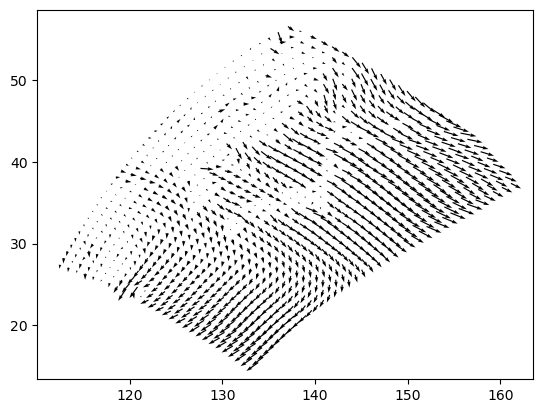

In [28]:
fig, ax = plt.subplots()
ax.quiver(ds7.lon[::20,::20], 
          ds7.lat[::20,::20], 
          ds7.u[::20,::20], 
          ds7.v[::20,::20])


東西風成分、南北風成分ともに、先に作成した``regridder``を再利用して空間内挿をおこなう。

In [29]:
u1 = ds7["u"]  # xarray.Datasetからxarray.DataArrayにする。
v1 = ds7["v"]
u2 = regridder(u1)
v2 = regridder(v1)


内挿した東西風成分u2を確認してみる。

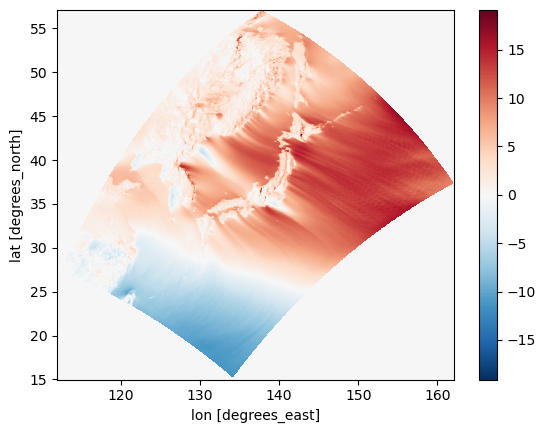

In [30]:
u2.plot()

内挿後の緯度・経度データを取り出し、``meshgrid``を用いて緯度・経度の2次元配列を作成する。

In [31]:
lon2 = u2["lon"]
lat2 = u2["lat"]
xx, yy = np.meshgrid(lon2, lat2)

u2とv2でNHRCMの計算領域外をmaskしてしまう。

In [32]:
u2_masked = u2.where(mask)
v2_masked = v2.where(mask)

マスクしたu2_maskedを確認する。

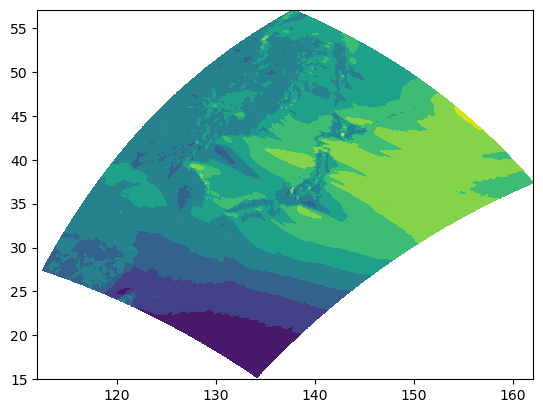

In [33]:
plt.contourf(xx, yy, u2_masked)

ランベルト正角円錐図法でu2_maskedを陰影で塗り分ける。

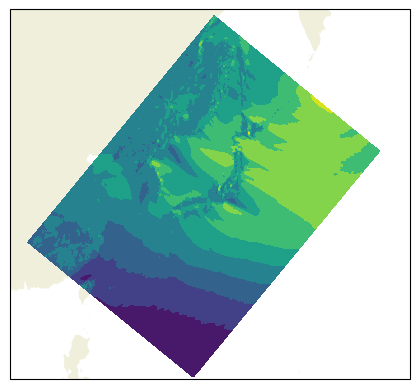

In [34]:
extent = [114, 158, 15, 56]

fig = plt.figure()
ax = plt.axes(
    projection=ccrs.LambertConformal(
        central_longitude=135,
        central_latitude=35,
        standard_parallels=(30,60)
    )
)
ax.set_extent(extent, ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.contourf(
    lon2,
    lat2,
    u2_masked,
    transform=ccrs.PlateCarree()
)

v2_maskedも同様に確認する。

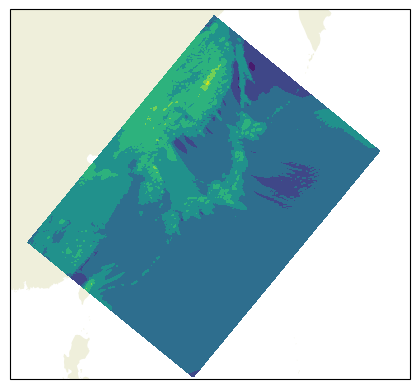

In [35]:
extent = [114, 158, 15, 56]

fig = plt.figure()
ax = plt.axes(
    projection=ccrs.LambertConformal(
        central_longitude=135,
        central_latitude=35,
        standard_parallels=(30,60)
    )
)
ax.set_extent(extent, ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.contourf(
    lon2,
    lat2,
    v2_masked,
    transform=ccrs.PlateCarree()
)

内挿後の風の場を``quiver``を用いてベクトル表示する。

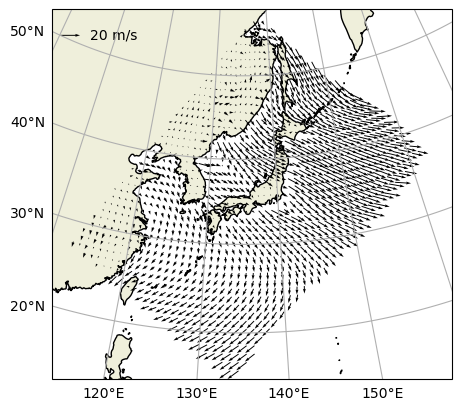

In [36]:
extent = [114, 158, 15, 56]

fig = plt.figure()
ax = plt.axes(
    projection=ccrs.LambertConformal(
        central_longitude=135,
        central_latitude=35,
        standard_parallels=(30,60)
    )
)
ax.set_extent(extent, ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)

# u2_masked/v2_maskedはvaluesを使って、numpy.ndarrayに変換する。
Q = ax.quiver(
    x=xx[::30,::30], 
    y=yy[::30,::30], 
    u=u2_masked[::30,::30].values, 
    v=v2_masked[::30,::30].values,
    scale=400,
    transform=ccrs.PlateCarree()
    )
ax.quiverkey(Q, 0.07, 0.93, 20, "20 m/s", labelpos="E")

ax.coastlines()

gl = ax.gridlines(
    draw_labels=True,
    x_inline=False,
    y_inline=False,
    xlocs=mticker.MultipleLocator(10),
    ylocs=mticker.MultipleLocator(10),
    linestyle="-"
)
gl.top_labels=False
gl.bottom_labels=True
gl.left_labels=True
gl.right_labels=False
gl.rotate_labels=False
